<a href="https://colab.research.google.com/github/dtoralg/IE_Calidad_ML/blob/main/Ejercicios/Modulo%206/Modulo_6_Ejercicio_3_Prediccion_Vida_Util_LSTM_Resuelto.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Ejercicio 3: Predicción de Vida Útil con Redes Neuronales Recurrentes**
## Modelado de series temporales para mantenimiento predictivo usando LSTM


En este ejercicio abordaremos un problema clásico de **mantenimiento predictivo** en entornos industriales: predecir cuántos ciclos de vida útil le quedan a un motor antes de fallar.

Trabajaremos con el dataset **CMAPSS - Turbofan Engine Degradation Simulation**, un conjunto de datos simulado por NASA que ha sido ampliamente utilizado en la literatura para explorar técnicas de modelado secuencial. El objetivo es construir un modelo que, a partir de secuencias de sensores, sea capaz de predecir la vida útil restante (RUL) de cada motor.

Utilizaremos una arquitectura basada en **Redes Neuronales Recurrentes (RNN)**, en particular una **LSTM (Long Short-Term Memory)**, comparando su rendimiento frente a un modelo de regresión tradicional como benchmark.

Al finalizar este ejercicio, habrás comprendido:

- Cómo preparar datos secuenciales para modelos recurrentes.
- Cómo implementar una red LSTM con Keras.
- Cómo evaluar el rendimiento de modelos secuenciales en tareas de regresión.


> Este cuaderno utiliza el dataset **C-MAPSS: Turbofan Engine Degradation Simulation** proporcionado por la **NASA Prognostics Center of Excellence**.
>
> Fuente oficial: [https://data.nasa.gov/Aeorspace/CMAPSS-Jet-Engine-Simulated-Data/ff5v-kuh6](https://data.nasa.gov/Aeorspace/CMAPSS-Jet-Engine-Simulated-Data/ff5v-kuh6)
>
> Licencia: **Dominio Público - US Government Work**  
Este dataset ha sido publicado por una agencia del gobierno de los Estados Unidos (NASA) y se encuentra en el **dominio público**, lo que permite su uso, distribución y modificación sin restricciones, incluyendo fines comerciales. Se recomienda atribuir la fuente como buena práctica.

In [ ]:
# Celda 1
# Cargamos las librerías necesarias

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.linear_model import LinearRegression
import math
import requests
import requests
import zipfile
import io

# Estilo visual para gráficos
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)
print("Entorno preparado correctamente.")


Entorno preparado correctamente.


In [ ]:
zip_url = "https://github.com/dtoralg/IE_Calidad_ML/raw/refs/heads/main/Data/Modulo%206/CMAPSSData.zip"

# Descargar el zip
response = requests.get(zip_url)

# Verificar que la descarga fue exitosa
if response.status_code == 200:
    # Leer el archivo ZIP en memoria
    zip_file = zipfile.ZipFile(io.BytesIO(response.content))

    # Mostrar el contenido del ZIP
    print("Archivos contenidos:")
    print(zip_file.namelist())

    # Extraer todos los archivos (opcional)
    zip_file.extractall("CMAPSS_data")  # Carpeta donde se guardarán
    print("Archivos extraídos en la carpeta 'CMAPSS_data'.")
else:
    print("Error al descargar el archivo:", response.status_code)

Archivos contenidos:
['Damage Propagation Modeling.pdf', 'readme.txt', 'RUL_FD001.txt', 'RUL_FD002.txt', 'RUL_FD003.txt', 'RUL_FD004.txt', 'test_FD001.txt', 'test_FD002.txt', 'test_FD003.txt', 'test_FD004.txt', 'train_FD001.txt', 'train_FD002.txt', 'train_FD003.txt', 'train_FD004.txt']
Archivos extraídos en la carpeta 'CMAPSS_data'.


In [ ]:
# Celda 2
# Vamos a utilizar los datos de CMAPSS del motor 1 (FD001)
# Como en test, el dataset nos ofrece el ciclo de fallo, no podemos usar LSTM (necesitamos una secuencia de puntos temporales)
# Por tanto aprovechamos la serie train, que si que tiene una secuencia temporal, para hacer nuestro modelo.

# Rutas de los archivos
train_url = '/content/CMAPSS_data/train_FD001.txt'

# Cargar las features
FD001_train = pd.read_csv(train_url, sep=" ", header=None)

cols = ['unit number', 'cycles', 'operational setting 1', 'operational setting 2',
          'operational setting 3'] + [f"sensor measurement {i}" for i in range(1, 24)]

FD001_train.columns = cols

In [ ]:
# Celda 3
# Analizamos la estructura del dataset
FD001_train.describe()

# Descripción del conjunto de datos
print(f"Número de registros: {FD001_train.shape[0]}")
print(f"Número de motores distintos: {FD001_train['unit number'].nunique()}")
print("\nColumnas del dataset:")
print(FD001_train.columns.tolist())

print("\nEjemplo de evolución temporal para un motor específico (unidad 1):")
FD001_train[FD001_train['unit number'] == 1].head()

Número de registros: 20631
Número de motores distintos: 100

Columnas del dataset:
['unit number', 'cycles', 'operational setting 1', 'operational setting 2', 'operational setting 3', 'sensor measurement 1', 'sensor measurement 2', 'sensor measurement 3', 'sensor measurement 4', 'sensor measurement 5', 'sensor measurement 6', 'sensor measurement 7', 'sensor measurement 8', 'sensor measurement 9', 'sensor measurement 10', 'sensor measurement 11', 'sensor measurement 12', 'sensor measurement 13', 'sensor measurement 14', 'sensor measurement 15', 'sensor measurement 16', 'sensor measurement 17', 'sensor measurement 18', 'sensor measurement 19', 'sensor measurement 20', 'sensor measurement 21', 'sensor measurement 22', 'sensor measurement 23']

Ejemplo de evolución temporal para un motor específico (unidad 1):


,unit number,cycles,operational setting 1,operational setting 2,operational setting 3,sensor measurement 1,sensor measurement 2,sensor measurement 3,sensor measurement 4,sensor measurement 5,...,sensor measurement 14,sensor measurement 15,sensor measurement 16,sensor measurement 17,sensor measurement 18,sensor measurement 19,sensor measurement 20,sensor measurement 21,sensor measurement 22,sensor measurement 23
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190,NaN,NaN
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236,NaN,NaN
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442,NaN,NaN
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739,NaN,NaN
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044,NaN,NaN


In [ ]:
# Verificar nulos
missing_ratio = FD001_train.isnull().mean()
print("Porcentaje de valores nulos por variable (top 10):")
print(missing_ratio.sort_values(ascending=False).head(10))

Porcentaje de valores nulos por variable (top 10):
sensor measurement 22    1.0
sensor measurement 23    1.0
unit number              0.0
cycles                   0.0
operational setting 3    0.0
sensor measurement 1     0.0
sensor measurement 2     0.0
sensor measurement 3     0.0
sensor measurement 4     0.0
sensor measurement 5     0.0
dtype: float64


In [ ]:
# Eliminar columnas con más del 25% de nulos
threshold = 0.25
cols_to_drop = missing_ratio[missing_ratio > threshold].index
FD001_train = FD001_train.drop(columns=cols_to_drop)

In [ ]:
# Quitamos aquellas columnas que son constantes y no añaden valor predictivo
columns_no_variation = FD001_train.columns[FD001_train.nunique() == 1]
FD001_train.drop(columns=columns_no_variation ,inplace=True)

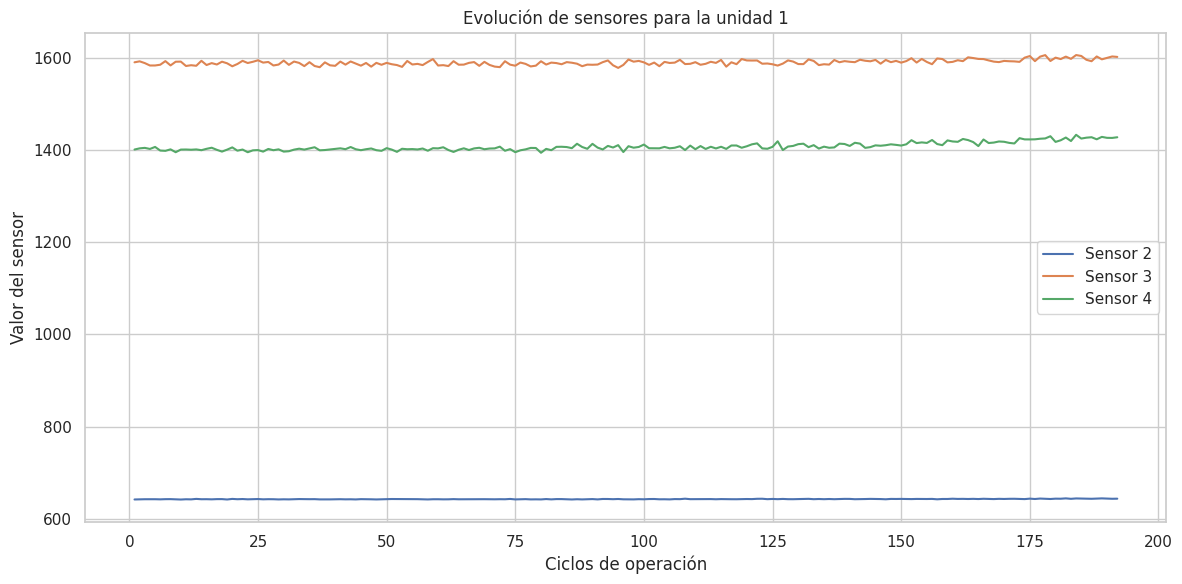

In [ ]:
# Celda 4
# Visualización de la evolución temporal de los sensores en una unidad

unit_example = 1
df_unit = FD001_train[FD001_train['unit number'] == unit_example]

sns.lineplot(data=df_unit, x='cycles', y='sensor measurement 2', label='Sensor 2')
sns.lineplot(data=df_unit, x='cycles', y='sensor measurement 3', label='Sensor 3')
sns.lineplot(data=df_unit, x='cycles', y='sensor measurement 4', label='Sensor 4')
plt.title('Evolución de sensores para la unidad 1')
plt.xlabel('Ciclos de operación')
plt.ylabel('Valor del sensor')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# Celda 5
# Cálculo del Remaining Useful Life (RUL) en train

rul_df = FD001_train.groupby('unit number')['cycles'].max().reset_index()
rul_df.columns = ['unit number', 'max cycle']

FD001_train_max = FD001_train.merge(rul_df, on='unit number', how='left')

In [ ]:
FD001_train_max['RUL'] = FD001_train_max['max cycle'] - FD001_train_max['cycles']
FD001_train_max.drop('max cycle', axis=1, inplace=True)
FD001_train_max[['unit number', 'cycles', 'RUL']].head()

,unit number,cycles,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


In [ ]:
# Celda 6
# Escalado de variables de sensores, nos centramos en predecir con ellas

features = [col for col in FD001_train_max.columns if 'sensor measurement' in col]

scaler = MinMaxScaler()
FD001_train_max[features] = scaler.fit_transform(FD001_train_max[features])
FD001_train_max[['unit number', 'cycles'] + features + ['RUL']].head()

,unit number,cycles,sensor measurement 2,sensor measurement 3,sensor measurement 4,sensor measurement 6,sensor measurement 7,sensor measurement 8,sensor measurement 9,sensor measurement 11,sensor measurement 12,sensor measurement 13,sensor measurement 14,sensor measurement 15,sensor measurement 17,sensor measurement 20,sensor measurement 21,RUL
0,1,1,0.183735,0.406802,0.309757,1.0,0.726248,0.242424,0.109755,0.369048,0.633262,0.205882,0.199608,0.363986,0.333333,0.713178,0.724662,191
1,1,2,0.283133,0.453019,0.352633,1.0,0.628019,0.212121,0.100242,0.380952,0.765458,0.279412,0.162813,0.411312,0.333333,0.666667,0.731014,190
2,1,3,0.343373,0.369523,0.370527,1.0,0.710145,0.272727,0.140043,0.250000,0.795309,0.220588,0.171793,0.357445,0.166667,0.627907,0.621375,189
3,1,4,0.343373,0.256159,0.331195,1.0,0.740741,0.318182,0.124518,0.166667,0.889126,0.294118,0.174889,0.166603,0.333333,0.573643,0.662386,188
4,1,5,0.349398,0.257467,0.404625,1.0,0.668277,0.242424,0.149960,0.255952,0.746269,0.235294,0.174734,0.402078,0.416667,0.589147,0.704502,187


In [ ]:
# Celda 7
# Creación de secuencias para entrenamiento de LSTM

def create_sequences(data, sequence_length=30):
    sequences = []
    labels = []
    for engine_id in data['unit number'].unique():
        engine_df = data[data['unit number'] == engine_id]
        for i in range(len(engine_df) - sequence_length):
            seq = engine_df.iloc[i:i+sequence_length][features].values
            label = engine_df.iloc[i+sequence_length]['RUL']
            sequences.append(seq)
            labels.append(label)
    return np.array(sequences), np.array(labels)

seq_length = 30
X, y = create_sequences(FD001_train_max, seq_length)

In [ ]:
# Celda 8
# División del dataset en entrenamiento y validación

split = int(0.8 * X.shape[0])
X_train, X_val = X[:split], X[split:]
y_train, y_val = y[:split], y[split:]

print(f"Train: {X_train.shape}, Validation: {X_val.shape}")


Train: (14104, 30, 15), Validation: (3527, 30, 15)


In [ ]:
# Celda 9
# Construcción y entrenamiento del modelo LSTM

model = Sequential()
model.add(LSTM(units=64, input_shape=(seq_length, len(features))))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')
model.summary()

history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_val, y_val), verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 64)                  │          20,480 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,545 (80.25 KB)

 Trainable params: 20,545 (80.25 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 7s 24ms/step - loss: 83.2906 - val_loss: 85.0538
Epoch 2/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 10s 23ms/step - loss: 67.4220 - val_loss: 76.4364
Epoch 3/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 25ms/step - loss: 59.6761 - val_loss: 70.3659
Epoch 4/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 55.2527 - val_loss: 66.2256
Epoch 5/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 11s 28ms/step - loss: 52.0830 - val_loss: 63.4729
Epoch 6/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 10s 26ms/step - loss: 50.1670 - val_loss: 61.7117
Epoch 7/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 26ms/step - loss: 49.2299 - val_loss: 60.3339
Epoch 8/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 44.9645 - val_loss: 48.0087
Epoch 9/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 33.1069 - val_loss: 41.6221
Epoch 10/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 5s 23ms/step - loss: 28.3244 - val_loss: 37.0867
Epoch 11/20
221/221 ━━━━━━━━━━━━━━━━━━━━ 6s 28ms/step - loss: 25.8741 - val_loss: 34.6460
Epoch 12/20
221/

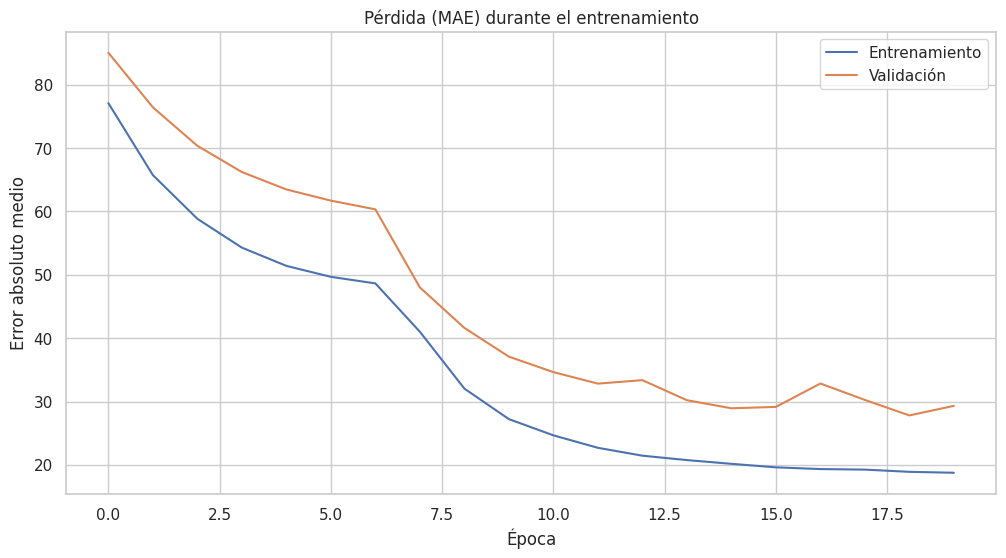

In [ ]:
# Celda 10
# Visualización de la pérdida durante el entrenamiento

plt.plot(history.history['loss'], label='Entrenamiento')
plt.plot(history.history['val_loss'], label='Validación')
plt.title('Pérdida (MAE) durante el entrenamiento')
plt.xlabel('Época')
plt.ylabel('Error absoluto medio')
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
# Celda 11
# Evaluación del modelo LSTM en validación

y_pred_val = model.predict(X_val)
mae_val = mean_absolute_error(y_val, y_pred_val)
rmse_val = math.sqrt(mean_squared_error(y_val, y_pred_val))
print(f"MAE LSTM: {mae_val:.2f}")
print(f"RMSE LSTM: {rmse_val:.2f}")


111/111 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
MAE LSTM: 29.32
RMSE LSTM: 46.18


In [ ]:
# Celda 12
# Comparación con modelo de regresión lineal

X_flat = X_train.reshape(X_train.shape[0], -1)
X_val_flat = X_val.reshape(X_val.shape[0], -1)

lr_model = LinearRegression()
lr_model.fit(X_flat, y_train)
y_lr_pred = lr_model.predict(X_val_flat)

mae_lr = mean_absolute_error(y_val, y_lr_pred)
rmse_lr = math.sqrt(mean_squared_error(y_val, y_lr_pred))
print(f"MAE Linear Regression: {mae_lr:.2f}")
print(f"RMSE Linear Regression: {rmse_lr:.2f}")


MAE Linear Regression: 32.14
RMSE Linear Regression: 45.67


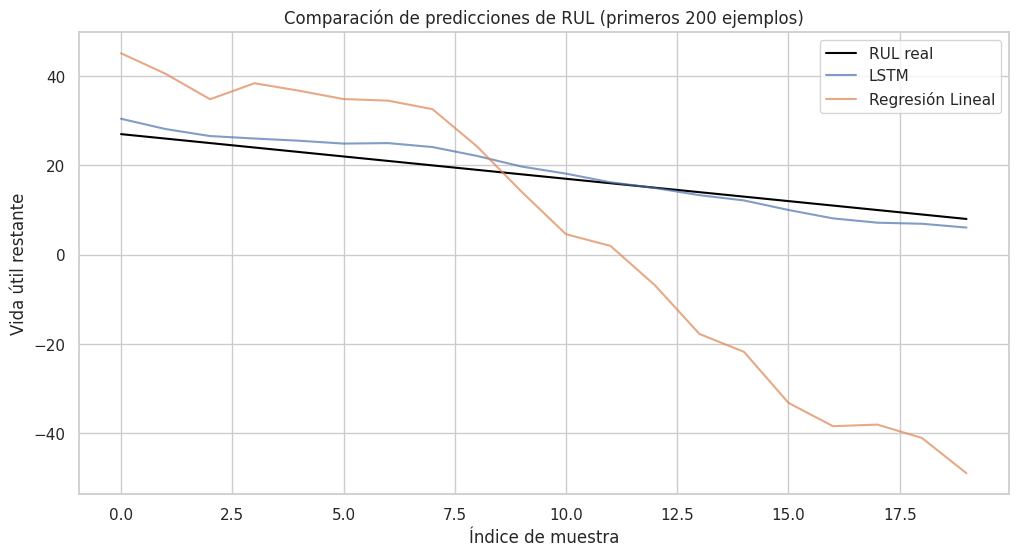

In [ ]:
# Celda 13
# Comparativa visual entre modelo LSTM y regresión lineal

plt.plot(y_val[:20], label='RUL real', color='black')
plt.plot(y_pred[:20], label='LSTM', alpha=0.7)
plt.plot(y_lr_pred[:20], label='Regresión Lineal', alpha=0.7)
plt.title('Comparación de predicciones de RUL (primeros 20 ejemplos)')
plt.xlabel('Índice de muestra')
plt.ylabel('Vida útil restante')
plt.legend()
plt.grid(True)
plt.show()


### Conclusiones
Este ejercicio ha demostrado cómo aplicar una arquitectura LSTM para predecir la vida útil restante (RUL) de motores industriales a partir de secuencias de sensores.

A diferencia de modelos tradicionales de regresión, las redes LSTM son capaces de capturar patrones temporales y dependencias en secuencias, lo cual se refleja en una mejora de métricas como MAE y RMSE.

En general, el modelo LSTM ha demostrado mejor capacidad de generalización que una regresión lineal, validando su idoneidad para tareas de predicción secuencial.

### Proximos Pasos
1. Optimización de hiperparámetros: número de capas LSTM, número de unidades, tamaño de secuencia, tasa de aprendizaje, etc.
2. Evaluación con otros datasets de CMAPSS (FD002, FD003, FD004) que presentan condiciones más complejas y múltiples modos de fallo.
3. Aplicación de técnicas de Transfer Learning para adaptar el modelo entrenado a nuevos motores con pocos datos disponibles.